## Optical Oscilloscope: Real-time filtering
---

This is the Jupyter Notebook for implementing my filtering algorithm with different parameters as well as comparison of the results with previously processed data.

### Imports

In [1]:
import numpy as np
import tifffile as tf
import matplotlib.pyplot as plt
import pandas as pd
import multiprocessing
from scipy import ndimage

#### Load and display the stack

In [2]:
file_path = 'data_from_paper.ome.tif'
stack = tf.imread(file_path)

Display the original image and a couple regions of interest that we will be working on. 

Text(0.5, 1.0, 'Cell 18')

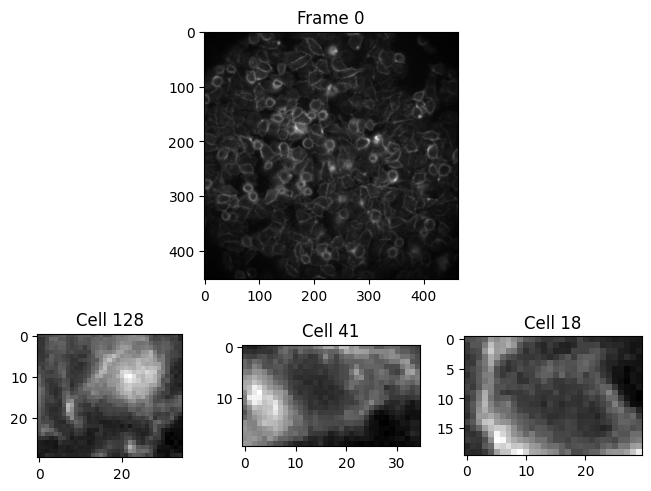

In [3]:
axd = plt.figure(layout='constrained').subplot_mosaic(
'''
AAA
BCD
''',
height_ratios=[2, 1],
width_ratios=[1, 1, 1]
)

axd['A'].imshow(stack[0, :, :], cmap='gray')
axd['A'].set_title('Frame 0')
axd['B'].imshow(stack[0, 235:265, 240:275], cmap='gray') # Cell 128
axd['B'].set_title('Cell 128')
axd['C'].imshow(stack[0, 95:115, 235:270], cmap='gray') # Cell 41
axd['C'].set_title('Cell 41')
axd['D'].imshow(stack[0, 50:70, 230:260], cmap='gray') # Cell 18
axd['D'].set_title('Cell 18')

### Filtering Algorithm

#### Function Definition

In [32]:
def filtering_single(x, y, batch_size=100):
    batch_size = 100  # Adjust the batch size as needed
    total_indices = len(stack) # stack is a global variable
    num_batches = total_indices // batch_size + (1 if total_indices % batch_size != 0 else 0)
    origin = (1000//2 - 1)
    raw_time_series = stack[:, x, y] - 90*16

    result_data = []

    for batch_idx in range(num_batches):
        start_index = batch_idx * batch_size
        end_index = min((batch_idx + 1) * batch_size, total_indices)

        result_data_batch = np.zeros((end_index // 2) + 1)

        for index in range(start_index, end_index, 2):
            blue = raw_time_series[:index:2].astype(float)
            green = raw_time_series[1:index:2].astype(float)
            blue /= ndimage.uniform_filter(blue, size=1000, mode='nearest', # Need to QUANTIFY analytically how it could be similar
                                            origin=origin)
            green /= ndimage.uniform_filter(green, size=1000, mode='nearest', # Need to QUANTIFY analytically how it could be similar
                                            origin=origin)
            frame = blue/green
            idx = int(index / 2)
            if frame.size != 0:
                result_data_batch[idx] = frame[idx-1]
        result_data.append(result_data_batch)
    return result_data

Now let's try the algorithm on a single pixel. The pixel we will track will correspond to a pixel in Cell 128.

In [33]:
result_data = filtering_single(245, 260) # Corresponds to a pixel in Cell 128

In [34]:
# Drop null values
for i in range(len(result_data)):
    result_data[i] = result_data[i][result_data[i] != 0]

In [35]:
result_data = np.concatenate(result_data) # Combine to one np array

In [36]:
result_data

array([1.        , 0.97243789, 0.96034245, ..., 0.96589802, 0.98943057,
       1.02900592])

Now let's plot the time series and compare it with the results from the paper. 

In [37]:
# First, define function for demean and offset-ing (?)
def prepare_plot(tseries, sigma):
    tseries_gauss = ndimage.gaussian_filter(tseries, sigma=sigma)
    tseries_gauss_demean = tseries_gauss - np.mean(tseries_gauss)
    offset = 1 - np.mean(tseries_gauss_demean)
    result_tseries = tseries_gauss_demean + offset

    return result_tseries

In [43]:
df_y_filtered = pd.read_csv('fig_3__3A_y_filtered.txt', sep=' ', header=None)
y_axis_filtered = df_y_filtered.iloc[10]
df_x = pd.read_csv('fig_3__3A_x.txt', sep=' ', header=None)

In [44]:
df_y = pd.read_csv('fig_3__3A_y.txt', sep=' ', header=None)
y_axis = df_y.iloc[10]

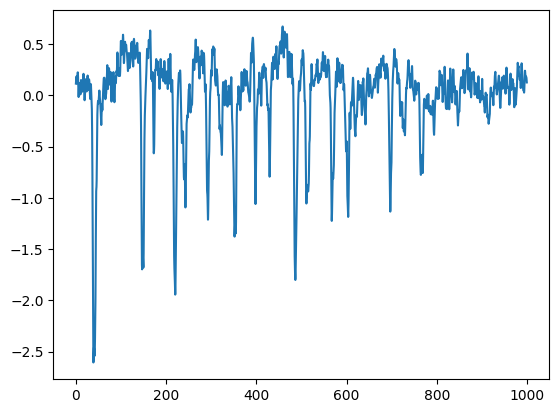

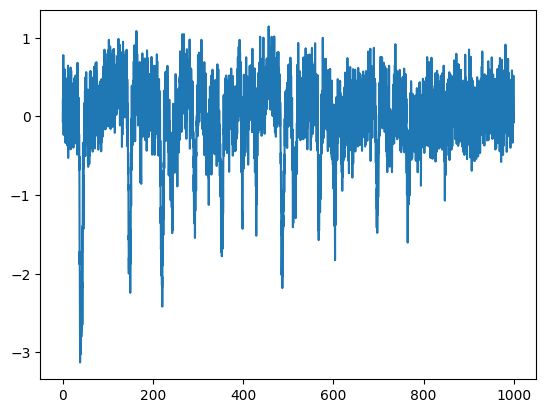

In [45]:
plt.plot(df_x, y_axis_filtered)
plt.show()
plt.plot(df_x, y_axis)
plt.show()

In [40]:
result_tseries = prepare_plot(result_data, 12)

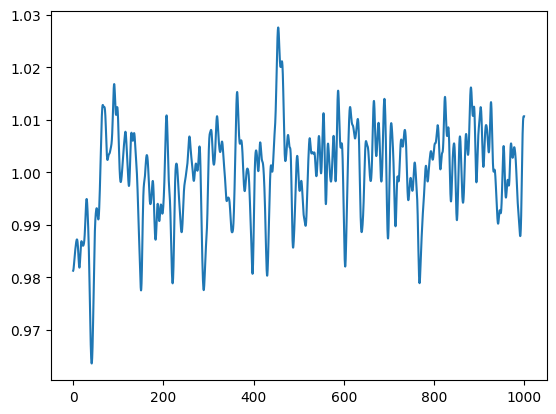

In [46]:
plt.plot(df_x, result_tseries)
plt.show()

Now take the median pixel value within the ROI, this might not give the best results just yet as the ROI is not circular (i.e. not bordering cell edges).

In [51]:
# Tweak the function
def filtering_roi(x1, x2, y1, y2, batch_size, type):
    # Adjust the batch size as needed
    total_indices = len(stack) # stack is a global variable
    num_batches = total_indices // batch_size + (1 if total_indices % batch_size != 0 else 0)
    origin = (1000//2 - 1)
    if type == 'median':
        raw_time_series = np.fromiter((np.mean(stack[i, x1:x2, y1:y2]) for i in range(len(stack))), dtype=float)
    elif type == 'mean':
        raw_time_series = np.fromiter((np.mean(stack[i, x1:x2, y1:y2]) for i in range(len(stack))), dtype=float)

    result_data = []

    for batch_idx in range(num_batches):
        start_index = batch_idx * batch_size
        end_index = min((batch_idx + 1) * batch_size, total_indices)

        result_data_batch = np.zeros((end_index // 2) + 1)

        for index in range(start_index, end_index, 2):
            blue = raw_time_series[:index:2].astype(float)
            green = raw_time_series[1:index:2].astype(float)
            blue /= ndimage.uniform_filter(blue, size=1000, mode='nearest', # Need to QUANTIFY analytically how it could be similar
                                            origin=origin)
            green /= ndimage.uniform_filter(green, size=1000, mode='nearest', # Need to QUANTIFY analytically how it could be similar
                                            origin=origin)
            frame = blue/green
            idx = int(index / 2)
            if frame.size != 0:
                result_data_batch[idx] = frame[idx-1]
        result_data.append(result_data_batch)
    return result_data

In [52]:
result_data = filtering_roi(235, 265, 240, 275, 100, 'median')
# Drop null values
for i in range(len(result_data)):
    result_data[i] = result_data[i][result_data[i] != 0]
result_data = np.concatenate(result_data) # Combine to one np array
result_data

array([1.        , 0.98416265, 0.9872458 , ..., 1.00217144, 1.00245759,
       1.00144294])

In [53]:
result_tseries = prepare_plot(result_data, 12)

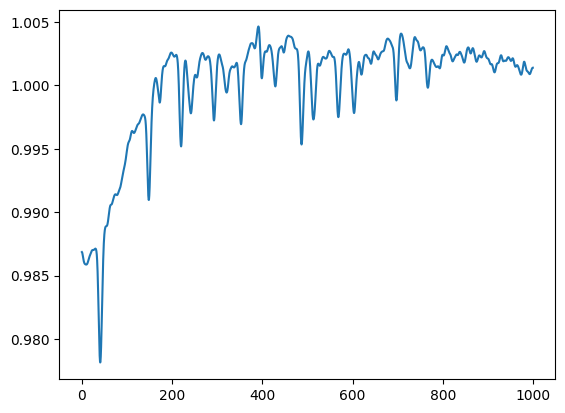

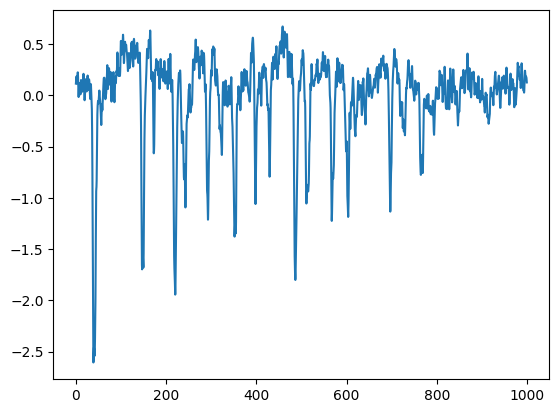

In [59]:
plt.plot(df_x, result_tseries)
plt.show()
plt.plot(df_x, y_axis_filtered)
plt.show()

In [67]:
def workflow(rowtup, coltup):
    (x1, x2) = rowtup
    (y1, y2) = coltup
    result_data = filtering_roi(x1, x2, y1, y2, 100, 'median')
    for i in range(len(result_data)):
        result_data[i] = result_data[i][result_data[i] != 0]
    result_data = np.concatenate(result_data)
    result_tseries = prepare_plot(result_data, 12)
    return result_tseries

In [64]:
row_tuples = [(235, 265), (95, 115), (50, 70)]
col_tuples = [(240, 275), (235, 270), (230, 260)]

In [65]:
# Store previously acquired data for plotting
cell_ids = [10, 13, 14]
previous_processed = []
for id in cell_ids:
    y_axis = df_y_filtered.iloc[id]
    previous_processed.append(y_axis)

In [68]:
current_processed = []
for i in range(3):
    result_tseries = workflow(row_tuples[i], col_tuples[i])
    current_processed.append(result_tseries)

Text(0.5, 1.0, 'Cell 18 - Algorithm')

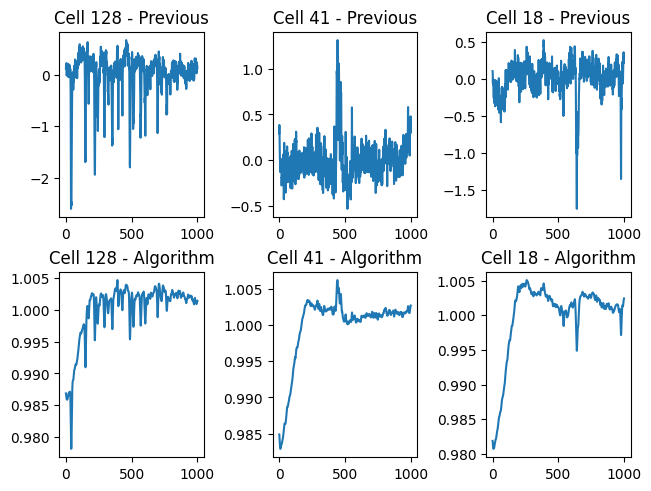

In [70]:
axd = plt.figure(layout='constrained').subplot_mosaic(
'''
ABC
DEF
''',
height_ratios=[1, 1],
width_ratios=[1, 1, 1]
)

axd['A'].plot(df_x, previous_processed[0])
axd['A'].set_title('Cell 128 - Previous')
axd['B'].plot(df_x, previous_processed[1])
axd['B'].set_title('Cell 41 - Previous')
axd['C'].plot(df_x, previous_processed[2])
axd['C'].set_title('Cell 18 - Previous')
axd['D'].plot(df_x, current_processed[0])
axd['D'].set_title('Cell 128 - Algorithm')
axd['E'].plot(df_x, current_processed[1])
axd['E'].set_title('Cell 41 - Algorithm')
axd['F'].plot(df_x, current_processed[2])
axd['F'].set_title('Cell 18 - Algorithm')